In [2]:
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pylab as plt
import os
import ecgprocpy3

# Import data

In [3]:
c_wd = os.getcwd()
directory= c_wd + '/data'
print(directory)
files = glob.glob(directory+"/*.csv")
datasets = []
for f in files:
    datasets.append(pd.read_csv(f, delimiter=' ', header = None,  usecols=[0]))

/Users/lorenaaldana/Documents/PhD_Thesis_Corrections/PhDThesis_w_corrections/IPNotebookThesis/ch9.code_sonification_methods/data


# Data exploration. Select a dataset either to to sonify it or plot it

Text(0.5, 0, 'Time [s]')

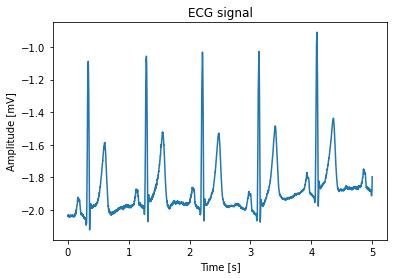

In [4]:
#select a dataset:
ecgdata = datasets[3]
sr = 1000.0
t= np.linspace(0, len(ecgdata)/sr, len(ecgdata))
t_1 = 0
t_2 = int(sr*5)
plt.plot(t[t_1:t_2],ecgdata[t_1:t_2])
plt.title('ECG signal'); plt.ylabel('Amplitude [mV]'); plt.xlabel ('Time [s]')

# Sonification methods

## Init sc3nb for sonifications:

In [5]:
#Remember to first install sc3nb to use SuperCollider from the Jupyter Notebook:
#https://github.com/interactive-sonification/sc3nb

In [6]:
from sc3nb.sc3nb import *

<IPython.core.display.Javascript object>

In [7]:
sc = startup(discard_output=True, verbose=True, liblo_flag=True)   
%scv s.scope
%scv s.freqscope

[1215/182805.302438:WARNING:resource_bundle_qt.cpp(115)] locale_file_path.empty() for locale 


sc3nb started
-> sc3nb started

-> localhost
sc3> s.scope
-> a Stethoscope

-> a FreqScope



If you need to exit SuperCollider use this line of code:

In [8]:
# sc.exit() 

In [9]:
#Functions implemented in the sonification methods (source code available at): 
#https://github.com/interactive-sonification/sc3nb
def dbamp(db):
    return 10**(db/20.0)
def linlin(x, smi, sma, dmi, dma): 
    return (x-smi)/(sma-smi)*(dma-dmi) + dmi
def midicps(m): 
    return 440.0*2**((m-69)/12.0)

#Note: the current Sc3Nb library already has such functions implemented. No need to run this cell if you have the latest version installed

## Polarity

Create the synth:

In [ ]:
%%scv
(
SynthDef("formant", { | freq=440, amp=0.2, pan=0, num=1|
    Out.ar(0, Pan2.ar( Formant.ar(freq.lag(0.1), freq, num.lag(0.05)*freq), pan, amp))
}).add();
)

In [ ]:
def polarity(data, band_passed = False, playback_rate=1, sr=1000.0, record=False):
     '''
    function to create a sonification using the polarity method.
    
    Input:
        low_passed. True or False. If true, the signal is band-passed to remove the low-frequency component that results from respiration.
        playback_rate: Float. playback rate of sonification. A value of 2 plays the sonification twice as fast. 
        sr: Float. signal's sample rate. 
    
    ''' 
    
    if band_passed:
        datf = ecgprocpy3.bpIIR_filter(data, 0.5, 50, sr)
        data = datf
        
    N, = np.shape(data)
    
    cmin = np.min(data); cmax = np.max(data) 
    #isoelectric reference:
    iso = np.mean(data) 

    #sonification duration depending on playback rate
    dur = N/sr/playback_rate
    #short delay before triggering the sonification:
    delay = 1.0
    
    #time reference to trigger the sonifications
    now = time.time()
    
    # Sonification:
    xid = 1001; sc.bundle(now, "/s_new", ["formant", xid, 0, 0])
    sc.bundle(now + 0.0 + dur, "/n_free", [xid] )
    # recording control
    if record:
        c_wd = os.getcwd()
        recname = 'polarity.wav'
        recdir = c_wd + '/recordings/'
        sc.prepare_for_record(0, recdir + recname, 9, 2, "wav", "int16")
        sc.record(now)
        sc.stop_recording(now + dur + delay)
        
    # mapping and sonification
    vm1 = 0
    for j, v in enumerate(data): # traverse row-wise
        onset = linlin(j, 0.0, N, 0, dur);
        amp = dbamp(linlin(abs(v-iso), 0, cmax, -10, 0))
        freq = midicps(linlin(v, cmin, cmax, 40, 70))
        num = linlin(v-iso, -0.1, 0.1, 1, 10)
        pan = clip(linlin(v - vm1, -0.1, 0.1, -1,1), -1, 1)
        sc.bundle(now + onset, "/n_set", [xid, "freq", freq, "pan", pan, "amp", amp, "num", num ])
        vm1 = v
        print(onset)
        
#call polarity sonification function:
sr = 1000
t_1 = 0
t_2 = int(sr*10)
data = ecgdata[0][t_1:t_2]

decim = 10
polarity(data, playback_rate=2.0, low_passed = True, sr = sr, record=True)

# Morph

In [10]:
%%scv
(
SynthDef("morph", { | vf=200, vrate=1, vdepth=1, amp=0.5, out=0, morphf=0.5, strfactor=1, dur=0.6, signalA, signalB, envA, envB, mix|
    signalA=LFPulse.ar(freq:Vibrato.kr(freq:vf, rate:vrate,depth:vdepth), width:0.5,mul:amp);
    envA=EnvGen.kr(Env.perc(attackTime: (dur*0.35)*strfactor, releaseTime: (dur*0.65)*strfactor, level: 0.7, curve: -7), doneAction:2);
    signalA=signalA * envA;
                   
    signalB= SinOsc.ar(freq:Vibrato.kr(freq:vf, rate:vrate,depth:vdepth) , mul:amp);
    envB=EnvGen.kr(Env.perc(attackTime: (dur*0.35)*strfactor, releaseTime:  (dur*0.65)*strfactor, level: 0.7, curve: -7), doneAction:2);
                   
    signalB=signalB * envB;
    mix = (signalA*morphf) + ((1-morphf)*signalB);
    Out.ar(0, mix!2);
                   
}).add();
)

-> a SynthDef



In [25]:
def morph(signal, sr, playback_rate, window, thpercentage, avgvalue = 10, record = False):
    '''
    function to create a sonification using the morph method.
    
    Input:
    
        sr: Float. signal's sample rate. 
        playback_rate: Float. playback rate of sonification. A value of 2 plays the sonification twice as fast. 
        window: Int. window size to look for R peaks. if the window is too large, it can miss peaks of an ECG signal exhibitin Tachycardia. 
        thpercentage: Float [0...1]. Percentage threshold to detect R peaks. A value of 0.5 means that amplitude values equal to or larger than 50% of the signal's amplitude are regarded as peaks. 
        avgvalue: Int. Number of previous R peaks consider when forecasting the next R peak. 
    
    '''
    N = len(signal)
    #reference time for the sonification
    tref = 0.0
    #duration of the sonification
    dur = N/sr/playback_rate
    #Extract signal features:
    pred_ma, pred_lr, peaks, rr, ma_cumu, _, rrma, rrlr = ecgprocpy3.actual_vs_predicted_onset_one_lead(signal, sr, window, thpercentage, avgvalue=avgvalue, plot = False)
    #Calculate the amplitude in the ST segments
    st_amp, hr = ecgprocpy3.st_amplitude_one_lead(signal, fc1=0.2, fc2= 50, accuracy = 0.1, st_length = 50, longer_qrs = 35, plot = False)


    #Onset
    now = time.time()
    delay = 1.0
    onset = 0;
    
    #Recording control
    if record == True:
        c_wd = os.getcwd()
        recname = 'morph.wav'
        recdir = c_wd + '/recordings/'
        sc.prepare_for_record(0, recdir + recname, 9, 2, "wav", "int16")
        sc.record(now)
        sc.stop_recording(now + dur + delay)     
    
    for pk in range(len(peaks)-1):
        #Update sonification onset according to peaks location
        onset = tref + rr[pk]/playback_rate
        tref = onset
        amp  = dbamp(-20)
        #Morphing factor
        morph_factor = linlin (np.abs(st_amp[pk]), 0, 0.4, 0, 1.0)
        sc.bundle(now+onset+delay, "/s_new", ["morph", -1, 0, 0, 'amp', amp, 'morphf', morph_factor, 'dur', 0.5, 'vf', 200, 'vrate', 1, 'vdepth', 1])

    
#call morph sonification function:
sr = 1000
t_1 = 0
t_2 = int(sr*20)
data = ecgdata[0][t_1:t_2]

morph(data, sr, playback_rate=1.0, window = 400, thpercentage = 0.7, avgvalue = 10, record=False)

# Water ambience

Create the synth:

In [14]:
%%scv
(
f = Buffer.readChannel(s,"sounds/Drop.wav",channels:[0], bufnum: 20);
SynthDef("water_ambience", {|buf, amp=0.5, out=0, rate=1.0, pan= 0.5, signal|
signal= PlayBuf.ar(1,buf, BufRateScale.kr(buf) * rate, doneAction:2);
signal= Pan2.ar(signal * amp, Line.kr(-0.8,0.8,1));
Out.ar(out,signal!2);
}).add()
)

-> a SynthDef



Sonification function:

In [18]:
def water_ambience(signal, sr, playback_rate, window, thpercentage, record = False):
    '''
    function to create a sonification using the water_ambience method.
    
    Input:
    
        sr: Float. signal's sample rate. 
        playback_rate: Float. playback rate of sonification. A value of 2 plays the sonification twice as fast. 
        window: Int. window size to look for R peaks. if the window is too large, it can miss peaks of an ECG signal exhibitin Tachycardia. 
        thpercentage: Float [0...1]. Percentage threshold to detect R peaks. A value of 0.5 means that amplitude values equal to or larger than 50% of the signal's amplitude are regarded as peaks. 
    
    '''
    
    
    N = len(signal)
    tref = 0.0
    dur = N/sr/playback_rate
    #Select starting water sound
    buf=20
    #Extract signal features:
    pred_ma, pred_lr, peaks, rr, ma_cumu, _, rrma, rrlr = ecgprocpy3.actual_vs_predicted_onset_one_lead(signal, sr, window, thpercentage, avgvalue=10, plot = False)
    #Calculate the amplitude in the ST segments
    st_amp, hr = ecgprocpy3.st_amplitude_one_lead(signal, fc1=0.2, fc2= 50, accuracy = 0.1, st_length = 50, longer_qrs = 35)
    #Onset
    now = time.time()
    start_onset = 0;
    end_onset = 0;
    #Drops
    max_drops = 5
    stretch_factor = 0.2 #200 ms for sr 1000.0, so the end of drops in one heartbeat don't overlap with first drop of the next heartbeat
    
          #Recording control
    if record == True:
        c_wd = os.getcwd()
        recname = 'water_ambience.wav'
        recdir = c_wd + '/recordings/'
        sc.prepare_for_record(0, recdir + recname, 9, 2, "wav", "int16")
        sc.record(now)
        sc.stop_recording(now + dur)  
    
    
    for pk in range(len(peaks)-1):
        #Number of drops
        num_drops = int(linlin (np.abs(st_amp[pk]), 0, 0.4, 1, max_drops)) #negative st_amp results in no drops without abs
        amp  = dbamp(-8)
        #Update sonification onset according to peaks location
        start_onset = (peaks[pk][0])/playback_rate
        end_onset = (start_onset + rr[pk])/playback_rate 
        
        #Create drops vector
        times_drops = np.linspace(start_onset, end_onset - stretch_factor, num_drops)

        #trigger drop sounds
        for dr in range(len(times_drops)):
            sc.bundle(now+times_drops[dr], "/s_new", ["water_ambience", -1, 0, 0, 'amp', amp, 'rate', 1.0, 'buf', buf, 'dur', 0.5])
        
    
#call water_ambience sonification function:
sr = 1000
t_1 = 0
t_2 = int(sr*20)
data = ecgdata[0][t_1:t_2]

water_ambience(data, sr, playback_rate=1.0, window = 400, thpercentage = 0.7, record=False)

# Stethoscope

Create the synth:

In [20]:
%%scv
(  
q = Buffer.readChannel(s,"sounds/HeartSound.wav",channels:[0], bufnum: 31);
    
SynthDef("stethoscope", { | amp=1,out=0, rate=1, pan=0, dur= 0.4, buf, start=0, freq_shift = 100, signal|
    signal= FreqShift.ar(PlayBuf.ar(1,buf, BufRateScale.kr(buf)* rate, start, loop:0,  doneAction:2), freq_shift, 0, 1, 0);
    signal=Pan2.ar(signal * amp * EnvGen.kr(Env.perc(0.2, BufDur.kr(buf), 1, curve:4)) , Line.kr(-0.8,0.8,1));
    Out.ar(out,signal);
}).add();
)

-> a SynthDef



Sonification function:

In [23]:
def stethoscope(signal, sr, playback_rate, window, thpercentage, record = False, recname = 'ST_Det_RH'):
     '''
    function to create a sonification using the stethoscope method.
    
    Input:
    
        sr: Float. signal's sample rate. 
        playback_rate: Float. playback rate of sonification. A value of 2 plays the sonification twice as fast. 
        window: Int. window size to look for R peaks. if the window is too large, it can miss peaks of an ECG signal exhibitin Tachycardia. 
        thpercentage: Float [0...1]. Percentage threshold to detect R peaks. A value of 0.5 means that amplitude values equal to or larger than 50% of the signal's amplitude are regarded as peaks. 
    
    '''
    
    N = len(signal)
    tref = 0.0
    dur = N/sr/playback_rate
    #Extract signal features:
    pred_ma, pred_lr, peaks, rr, ma_cumu, _, rrma, rrlr = ecgprocpy3.actual_vs_predicted_onset_one_lead(signal, sr, window, thpercentage, avgvalue=10, plot = False)
    #Calculate the amplitude in the ST segments
    st_amp, hr = ecgprocpy3.st_amplitude_one_lead(signal, fc1=0.2, fc2= 70, accuracy = 0.1, st_length = 50, longer_qrs = 35)
    #Onset
    now = time.time()
    onset = 0;
    
        #Recording control
    if record == True:
        c_wd = os.getcwd()
        recname = 'stethoscope.wav'
        recdir = c_wd + '/recordings/'
        sc.prepare_for_record(0, recdir + recname, 9, 2, "wav", "int16")
        sc.record(now)
        sc.stop_recording(now + dur) 
    
    for pk in range(len(rr)):
        #Update sonification onset according to peaks location
        onset = tref + rr[pk]/playback_rate
        tref = onset
        amp  = dbamp(0)
        #frequency shift mapping
        freq_shift = int(linlin(np.abs(st_amp[pk]), 0, 0.4, 100, 500)) 
        #trigger the sounds
        sc.bundle(now+onset, "/s_new", ["stethoscope", -1, 0, 0, 'buf', 31, 'amp', 2, 'freq_shift',freq_shift , 'rate', 1])

#call stethoscope sonification function:
sr = 1000
t_1 = 0
t_2 = int(sr*20)
data = ecgdata[0][t_1:t_2]

stethoscope(data, sr, playback_rate=1.0, window = 400, thpercentage = 0.7, record = True)